# Imports

In [1]:
import numpy as np
import sympy as sp
from sympy import *
import re

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams

from math import log10, floor
from math import *
import math

from IPython.display import display, Latex
from IPython.display import Markdown as md

import scipy.constants as pc
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats

# Matplotlib Style changes

In [2]:
rcParams['font.size'] = 15
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams["xtick.minor.size"] =  4
rcParams["ytick.minor.size"] =  4
rcParams["xtick.minor.visible"] =  True
rcParams["ytick.minor.visible"] =  True

# Statistical Selfcoded functions

In [3]:
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)


# easier formula for gaussian error propagation with addition
def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

# easier formula for gaussian error propagation with multiplication
def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

# Formlae for Gaußen Error propagation with result
def DivisionMitFehler(A, deltaA, B, deltaB): # Für C=A/B
    C = A/B
    deltaC = abs(C) * math.sqrt((deltaA / A)**2 + (deltaB / B)**2)
    return C,deltaC

def MultiplikationMitFehler(A, deltaA, B, deltaB): #Für C=A*B
    C = A * B
    deltaC = abs(C) * ((deltaA / abs(A)) + (deltaB / abs(B)))
    return C, deltaC

# t-value for without literature value
def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)+(stu_2**2))))

# analytic linear regression y(x)=m*x + b calculates m
def bestM(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression y(x)=m*x + b calculates b
def bestB(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression calculates variance 
# (only used for next two functions, never gets called on its own, enhances readability) 
def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestB(x, y)+bestM(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

# analytic linear regression y(x)=m*x + b calculates error on m
def stuM(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

# analytic linear regression y(x)=m*x + b calculates error on b
def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))


# Ergebnisse des Versuchs Lasergyroskop

Wichtige Anmerkungen zu den Codekonventionen:
- Variablennamen nutzen CamelCase und kürzen ab z.B.: linsenAbstandGegenstand was dem Abstand der Linse von der Gegenstandseite entspricht
- Fehler werden hierbei mit dem Suffix Err im CamelCase gekennzeichnet z.B.: abstandErr entspricht dem Fehler der Abstandsvariable 
- Einheiten stehen kommentiert nach den Einheiten z.B.: x = 3 # mm oder "vMax = 2 # V"

## Versuchsablauf 
Vor Beginn der Aufnahme der Messreihen wurde die Interferenzoptik des Lasergyroskops justiert. Dabei wurden der Spiegel so justiert, dass die beiden Strahlen, der clockwise (cw), sowie der counterclockwise (ccw) etwas hinter der Position einer der beiden Photodioden direkt aufeinanderlagen daraufhin wurde der Beamsplitter so justiert, dass die beiden Strahlen auf einer 4 Meter entfernten Wand auch übereinanderlagen. Daraufhin war ein Ringinterferenzmuster sichtbar. Durch dessen Form wurde der Mittelpunkt ermittelt und das gleiche Verfahren wurde durchgeführt um dafür zu sorgen, dass die beiden Strahlen sich in der Mitte dieses Interferentmusters trafen. Der Helium-Neon-Laser selbst musste nicht justiert werden, da dieser bereits vorjustiert war.
Daraufhin wurde eine Testmessreihe aufgenommen, bei dem für jede mögliche Einstellung der Drehtischgeschwindigkeit [0.1, 0.2, 0.3, 0.4, 0.6, ..., 1.8, 2.0] & [1, 2, 3, 4, 6, ..., 18, 20] eine Messung aufgenommen wurde um den ungefähren Trend erkennbar zu machen. Da dieser der physikalischen Erwartung entsprach wurden daraufhin die, für die Auswertung benutzten Messdaten gemessen. Für jede der oben erwähnten Gradanzahlen wurden 12 Werte am Frequenzzähler ausgelesen.
Die daraus resultierenden Werte und Auswertung befinden sich im folgenden Kapitel. 

## Messung des feinen Bereichs (0.1-2.0)

### Einschreibung der Werte
Die Werte wurde im Laborheft vor Ort direkt festgehalten und später von diesem übertragen. 

#### Werte fein CW

In [4]:
feinBerCw = np.append(np.arange(0.1, 0.5, 0.1), np.arange(0.6, 2.2, 0.2))
feinBerCwFreq1 = np.array([0])
feinBerCwFreq2 = np.array([0])
feinBerCwFreq3 = np.array([0])
feinBerCwFreq4 = np.array([330, 450, 100, 200, 350, 270, 162, 198, 205, 152, 236, 192])/100 # kHz
feinBerCwFreq6 = np.array([260, 225, 272, 183, 204, 169, 292, 268, 188, 258, 141, 173])/100 # kHz
feinBerCwFreq8 = np.array([159, 237, 205, 281, 278, 163, 259, 202, 397, 316, 318, 250])/100 # kHz
feinBerCwFreq10 = np.array([190, 290, 271, 265, 314, 293, 263, 230, 246, 242, 244, 266])/100 # kHz
feinBerCwFreq12 = np.array([363, 420, 580, 395, 243, 287, 350, 251, 351, 306, 342, 274])/100 # kHz
feinBerCwFreq14 = np.array([373, 391, 281, 337, 539, 306, 410, 389, 695, 621, 700, 419])/100 # kHz
feinBerCwFreq16 = np.array([413, 258, 204, 566, 298, 441, 298, 963, 307, 610, 596, 632])/100 # kHz
feinBerCwFreq18 = np.array([964, 1220, 245, 1208, 991, 758, 252, 326, 324, 840, 309, 320])/10 # kHz
feinBerCwFreq20 = np.array([628, 1318, 2430, 304, 295, 1170, 1355, 1359, 1358, 1372, 1274, 766])/10 # kHz


feinBerCwFreqArr = np.array([am(feinBerCwFreq1), am(feinBerCwFreq2), am(feinBerCwFreq3), am(feinBerCwFreq4), am(feinBerCwFreq6),
                             am(feinBerCwFreq8), am(feinBerCwFreq10), am(feinBerCwFreq12), am(feinBerCwFreq14), am(feinBerCwFreq16), 
                             am(feinBerCwFreq18), am(feinBerCwFreq20)])

feinBerCwFreqArrErr = np.array([stu(feinBerCwFreq1), stu(feinBerCwFreq2), stu(feinBerCwFreq3), stu(feinBerCwFreq4), 
                                stu(feinBerCwFreq6), stu(feinBerCwFreq8), stu(feinBerCwFreq10), stu(feinBerCwFreq12), 
                                stu(feinBerCwFreq14), stu(feinBerCwFreq16), stu(feinBerCwFreq18), stu(feinBerCwFreq20)])


<ipython-input-3-8ab7db670773>:8: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(summen_der_quadrate/(werte.size-1))


In [5]:
feinBerCcw = -np.append(np.arange(0.1, 0.5, 0.1), np.arange(0.6, 2.2, 0.2))
feinBerCcwFreq1 = np.array([0])
feinBerCcwFreq2 = np.array([0])
feinBerCcwFreq3 = np.array([0])
feinBerCcwFreq4 = np.array([161, 200, 83, 138, 176, 183, 190, 268, 168, 113, 187, 152])/100 # kHz
feinBerCcwFreq6 = np.array([203, 323, 184, 197, 278, 298, 284, 274, 253, 283, 261, 278])/100 # kHz
feinBerCcwFreq8 = np.array([214, 282, 258, 225, 172, 241, 249, 237, 254, 224, 201, 146])/100 # kHz
feinBerCcwFreq10 = np.array([421, 450, 334, 336, 407, 356, 324, 363, 256, 268, 371, 413])/100 # kHz
feinBerCcwFreq12 = np.array([441, 603, 268, 409, 686, 271, 342, 475, 263, 261, 226, 349])/100 # kHz
feinBerCcwFreq14 = np.array([429, 393, 375, 843, 611, 291, 398, 558, 814, 590, 339, 473])/100 # kHz
feinBerCcwFreq16 = np.array([915, 863, 298, 704, 265, 258, 363, 260, 1170, 1133, 313, 583])/100 # kHz
feinBerCcwFreq18 = np.array([272, 238, 335, 509, 789, 305, 302, 1248, 1187, 1271, 736, 1285])/10 # kHz
feinBerCcwFreq20 = np.array([1029, 606, 657, 927, 1110, 1390, 1246, 261, 1173, 481, 686, 1361])/10 # kHz

feinBerCcwFreqArr = np.array([am(feinBerCcwFreq1), am(feinBerCcwFreq2), am(feinBerCcwFreq3), am(feinBerCcwFreq4), am(feinBerCcwFreq6),
                             am(feinBerCcwFreq8), am(feinBerCcwFreq10), am(feinBerCcwFreq12), am(feinBerCcwFreq14), am(feinBerCcwFreq16), 
                             am(feinBerCcwFreq18), am(feinBerCcwFreq20)])

feinBerCcwFreqArrErr = np.array([stu(feinBerCcwFreq1), stu(feinBerCcwFreq2), stu(feinBerCcwFreq3), stu(feinBerCcwFreq4), 
                                stu(feinBerCcwFreq6), stu(feinBerCcwFreq8), stu(feinBerCcwFreq10), stu(feinBerCcwFreq12), 
                                stu(feinBerCcwFreq14), stu(feinBerCcwFreq16), stu(feinBerCcwFreq18), stu(feinBerCcwFreq20)])

<ipython-input-3-8ab7db670773>:8: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(summen_der_quadrate/(werte.size-1))


In [6]:
#1
grobBerCwFreq1 = np.array([613,591,570,549,543,600,571,595,594,592,580,579])*10/100 # kHz
grobBerCcwFreq1 = np.array([702,509,405,694,684,501,617,659,382,702,707,452])*10/100 # kHz

#2
grobBerCwFreq2 = np.array([1336,6970,1342,1003,1155,905,1160,928,917,1350,818,914])*10/100 # kHz
grobBerCcwFreq2 = np.array([1087,929,1155,1422,792,1207,703,1225,1416,1387,847,752])*10/100 # kHz

#3
grobBerCwFreq3 = np.array([1944,2029,1417,1350,1711,1394,1341,1314,1782,1542,1886,1504])*10/100 # kHz
grobBerCcwFreq3 = np.array([2123,1780,2112,2086,2077,2039,1975,1189,1114,1806,2065,1823])*10/100 # kHz

#4
grobBerCwFreq4 = np.array([2708,2672,1415,2411,2753,2756,2722,1470,1983,2641,2176,2665])*10/100 # kHz
grobBerCcwFreq4 = np.array([2237,1571,1611,2794,2834,2844,2150,2815,2836,2812,2839,2857])*10/100 # kHz

#6
grobBerCwFreq6 = np.array([4015,3571,4044,3987,3781,4084,3751,3981,4058,2251,3791,3741])*10/100 # kHz
grobBerCcwFreq6 = np.array([2331,3931,3587,4119,2421,1971,4089,1971,3791,4110,2417,2171])*10/100 # kHz

#8
grobBerCwFreq8 = np.array([5310,5119,4576,4261,4371,3947,4396,4487,5343,4972,4327,4972])*10/100 # kHz
grobBerCcwFreq8 = np.array([3867,3298,5150,5234,4605,5392,4309,4443,2170,4580,5305,5153])*10/100 # kHz

#10
grobBerCwFreq10 = np.array([4930,4470,4682,4543,5814,1920,5542,2411,6170,6258,5676,6540])*10/100 # kHz
grobBerCcwFreq10 = np.array([3070,4201,3680,4812,3210,4287,5739,3621,5883,6167,5446,6455])*10/100 # kHz

#12
grobBerCwFreq12 = np.array([7140,7670,8337,7920,7498,7612,7590,6660,6111,8004,6241,4905])*10/100 # kHz
grobBerCcwFreq12 = np.array([4370,7968,6264,5851,7949,6662,7806,7535,8163,7735,7678,5069])*10/100 # kHz

#14
grobBerCwFreq14 = np.array([794,951,720,646,867,951,652,914,724,944,788,712])*100/100 # kHz
grobBerCcwFreq14 = np.array([718,937,921,929,873,738,852,891,643,800,936,811])*100/100 # kHz

#16
grobBerCwFreq16 = np.array([104,111,87,64,74,110,91,108,82,108,91,86])*1000/100 # kHz
grobBerCcwFreq16 = np.array([643,641,957,846,634,745,731,733,682,857,952,997])*100/100 # kHz

#18
grobBerCwFreq18 = np.array([810,809,559,585,860,550,673,470,667,507,699,804])*100/100 # kHz
grobBerCcwFreq18 = np.array([630,683,591,614,604,643,434,755,549,736,631,846])*100/100 # kHz

#20
grobBerCwFreq20 = np.array([699,903,1020,953,602,989,993,610,724,1004,1048,1090])*100/100 # kHz
grobBerCcwFreq20 = np.array([802,908,708,1040,598,565,827,776,827,1063,1072,554])*100/100 # kHz


grobBerCwFreqArr = np.array([am(grobBerCwFreq1), am(grobBerCwFreq2), am(grobBerCwFreq3), am(grobBerCwFreq4), am(grobBerCwFreq6),
                           am(grobBerCwFreq8), am(grobBerCwFreq10), am(grobBerCwFreq12), am(grobBerCwFreq14), am(grobBerCwFreq16), 
                           am(grobBerCwFreq18), am(grobBerCwFreq20)])

grobBerCwFreqArrErr = np.array([stu(grobBerCwFreq1), stu(grobBerCwFreq2), stu(grobBerCwFreq3), stu(grobBerCwFreq4), 
                                stu(grobBerCwFreq6), stu(grobBerCwFreq8), stu(grobBerCwFreq10), stu(grobBerCwFreq12), 
                                stu(grobBerCwFreq14), stu(grobBerCwFreq16), stu(grobBerCwFreq18), stu(grobBerCwFreq20)])

grobBerCw = np.append(np.arange(1, 5, 1), np.arange(6, 22, 2))


grobBerCcwFreqArr = np.array([am(grobBerCcwFreq1), am(grobBerCcwFreq2), am(grobBerCcwFreq3), am(grobBerCcwFreq4), am(grobBerCcwFreq6),
                           am(grobBerCcwFreq8), am(grobBerCcwFreq10), am(grobBerCcwFreq12), am(grobBerCcwFreq14), am(grobBerCcwFreq16), 
                           am(grobBerCcwFreq18), am(grobBerCcwFreq20)])

grobBerCcwFreqArrErr = np.array([stu(grobBerCcwFreq1), stu(grobBerCcwFreq2), stu(grobBerCcwFreq3), stu(grobBerCcwFreq4), 
                                stu(grobBerCcwFreq6), stu(grobBerCcwFreq8), stu(grobBerCcwFreq10), stu(grobBerCcwFreq12), 
                                stu(grobBerCcwFreq14), stu(grobBerCcwFreq16), stu(grobBerCcwFreq18), stu(grobBerCcwFreq20)])

grobBerCcw = -np.append(np.arange(1, 5, 1), np.arange(6, 22, 2))

### Kalibrierungsdaten Drehtischgeschwindigkeit
Die Skaleneinheiten des Drehtischs sind keine direkten Winkelgeschwindigkeiten, sondern recht arbiträr, im folgenden sind die, aus dem Manual ([Quelle](https://ilias.uni-freiburg.de/goto.php?target=file_3186533_download&client_id=unifreiburg)) des Laser Gyroskops entnommenen, Winkelgeschwindigkeiten in °/s für die einzelnen Stufen angegeben.

In [9]:
geschFeinCw = np.array([0.078, 0.169, 0.269, 0.348, 0.545, 0.724, 0.922, 1.085, 1.334, 1.556, 1.716, 2.008])
geschFeinCcw = np.array([.114, .223, .324, .462, .680, .974, 1.027, 1.249, 1.522,  1.741, 1.915, 2.089])
geschFeinErr = np.array([2, 3, 4, 6, 7, 8, 9, 10, 10, 12, 14, 16])*1e-3
geschGrobCw = np.array([0.922, 2.008, 2.996, 4.06, 6.08, 8.06, 10.21, 12.5, 14.39, 16.53, 18.64, 21.04])
geschGrobCcw = np.array([1.027, 2.089, 3.06, 4.06, 5.92, 7.8, 9.73, 11.72, 13.54, 15.35, 17.18, 19.38])
geschGrobErr = np.array([9, 16, 25, 20, 60, 80, 60, 80, 90, 100, 120, 150])*1e-3

### Aufzeichnen der Daten

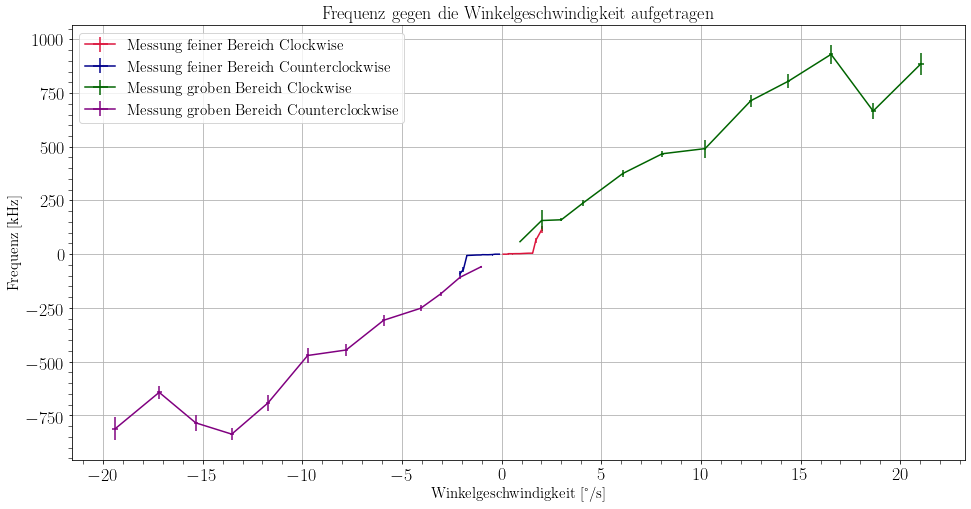

In [11]:
# Plotgröße anpassen
plt.figure(figsize=(16, 8))

# Gemessene Spannungswerte auftragen
plt.errorbar(geschFeinCw, feinBerCwFreqArr, xerr=geschFeinErr, yerr=feinBerCwFreqArrErr, color='crimson', label="Messung feiner Bereich Clockwise")
plt.errorbar(-geschFeinCcw, -feinBerCcwFreqArr, xerr=geschFeinErr, yerr=feinBerCcwFreqArrErr, color='darkblue', label="Messung feiner Bereich Counterclockwise")
plt.errorbar(geschGrobCw, grobBerCwFreqArr, xerr=geschGrobErr, yerr=grobBerCwFreqArrErr, color='darkgreen', label="Messung groben Bereich Clockwise")
plt.errorbar(-geschGrobCcw, -grobBerCcwFreqArr, xerr=geschGrobErr, yerr=grobBerCcwFreqArrErr, color='purple', label="Messung groben Bereich Counterclockwise")
np.linspace
plt.plot()

# labels und legend
plt.xlabel(r'Winkelgeschwindigkeit [°/s]')
plt.ylabel(r'Frequenz [kHz]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Frequenz gegen die Winkelgeschwindigkeit aufgetragen')
plt.show()

### Fits berechnen

platueMean 0.19223382085843466 platueMeanErr 2.0616035797558438e-06


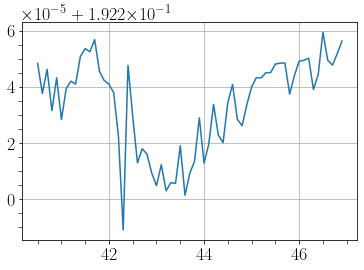

In [6]:
#Spannung des Plateaus berechnen - entspricht Temperatur von flüssigem Stickstoff

def timeToIndices(timeStart, timeEnd, timeArray):
    # Index finden, welcher dem gewünschten Zeitwert Entspricht
    startIndex = np.argmax(timeArray >= timeStart)
    endIndex = np.argmax(timeArray >= timeEnd)
    
    return startIndex, endIndex


def clearNaNs(xArray,yArray):
    nanMask = np.isnan(yArray)
    nanIndices = np.where(nanMask)
    
    xArrayClean = np.delete(xArray, nanIndices[0])
    yArrayClean = np.delete(yArray, nanIndices[0])
    
    return xArrayClean, yArrayClean
    

startTimePlateu = 40.5
endTimePlateu = 47

startIndexPlateu, endIndexPlateu = timeToIndices(startTimePlateu, endTimePlateu, zeitKupferMessung)

#Slicen der Arrays für den Fit
xDataPlateuUnclean = zeitKupferMessung[startIndexPlateu:endIndexPlateu]
yDataPlateuUnclean = spannungUA1KupferMessung[startIndexPlateu:endIndexPlateu]
    
#Entfernen von NaN Werten
xDataPlateu = clearNaNs(xDataPlateuUnclean,yDataPlateuUnclean)[0]
yDataPlateu = clearNaNs(xDataPlateuUnclean,yDataPlateuUnclean)[1]

# Bestimmung Mittelwert Plateu
platueMean = np.mean(yDataPlateu)
platueMeanErr = np.std(yDataPlateu, ddof=1) / np.sqrt(len(yDataPlateu))

#Ausgabe Spannung PLateu Mittelwer
print("platueMean",platueMean,"platueMeanErr",platueMeanErr)

# PLateu Plotten 
plt.plot(xDataPlateu,yDataPlateu)

<ipython-input-7-1ad765091b7d>:25: RuntimeWarning: invalid value encountered in sqrt
  standardErrors = np.sqrt(np.diag(covariance))


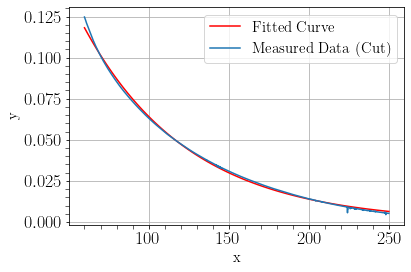

Fitted Parameters:
d = -2e-04 ± 1e-04 Entspricht unserer Spannung bei Raumtemperatur


In [7]:
# Berechnen von Fits 

# Define the exponential function
def exponentialFunc(x, a, b, c, d):
    return a * np.exp(b * x + c) + d


def fitExponential(xData,yData,startTime,endTime,initialGuesses):
    
    startIndex = timeToIndices(startTime, endTime, xData)[0]
    endIndex = timeToIndices(startTime, endTime, xData)[1]
    
    # Slicen der Arrays für den Fit
    xDataFitUnclean = xData[startIndex:endIndex]
    yDataFitUnclean = yData[startIndex:endIndex]
    
    # Entfernen von NaN Werten
    xDataFit = clearNaNs(xDataFitUnclean,yDataFitUnclean)[0]
    yDataFit = clearNaNs(xDataFitUnclean,yDataFitUnclean)[1]
    
    # Curve Fit mittels scypy
    params, covariance = curve_fit(exponentialFunc, xDataFit, yDataFit,
                                   p0=initialGuesses,maxfev = 80000)
    
    standardErrors = np.sqrt(np.diag(covariance))
    
    # Parameter Extrahieren
    aFit, bFit, cFit, dFit = params
    
    
    xFit = np.linspace(min(xDataFit), max(xDataFit), 100)
    yFit = exponentialFunc(xFit, aFit, bFit, cFit, dFit)
    
    fitReturn = aFit, bFit, cFit, dFit, standardErrors, xFit, yFit, xDataFit, yDataFit
    
    return fitReturn


initialGuesses5 = np.array([0.00001,-0.01,10,0])
fitKupfer5 = fitExponential(zeitKupferMessung, spannungUA1KupferMessung,60,250,initialGuesses5)




# Initial Guess Plot
# plt.plot(np.linspace(60,250,100),exponentialFunc(np.linspace(60,250,100),
#                   initialGuesses5[0], initialGuesses5[1], initialGuesses5[2], initialGuesses5[3]))

# Originale und Fittet Curve Plotten
plt.errorbar(fitKupfer5[7], fitKupfer5[8], label="Measured Data (Cut)")
plt.plot(fitKupfer5[5], fitKupfer5[6], 'r-', label="Fitted Curve")

# Plot Labeln
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameters
print("Fitted Parameters:")
print(f"d = {fitKupfer5[3]:.0e} ± {fitKupfer5[4][3]:.0e} Entspricht unserer Spannung bei Raumtemperatur")

<ipython-input-8-1ad765091b7d>:25: RuntimeWarning: invalid value encountered in sqrt
  standardErrors = np.sqrt(np.diag(covariance))


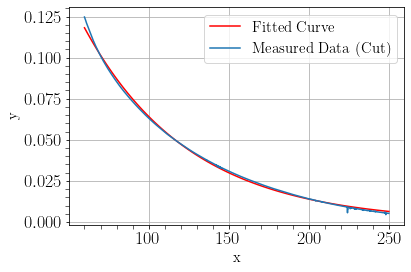

Fitted Parameters:
d = -2e-04 ± 1e-04 Entspricht unserer Spannung bei Raumtemperatur


In [8]:
# Berechnen von Fits 

# Define the exponential function
def exponentialFunc(x, a, b, c, d):
    return a * np.exp(b * x + c) + d


def fitExponential(xData,yData,startTime,endTime,initialGuesses):
    
    startIndex = timeToIndices(startTime, endTime, xData)[0]
    endIndex = timeToIndices(startTime, endTime, xData)[1]
    
    # Slicen der Arrays für den Fit
    xDataFitUnclean = xData[startIndex:endIndex]
    yDataFitUnclean = yData[startIndex:endIndex]
    
    # Entfernen von NaN Werten
    xDataFit = clearNaNs(xDataFitUnclean,yDataFitUnclean)[0]
    yDataFit = clearNaNs(xDataFitUnclean,yDataFitUnclean)[1]
    
    # Curve Fit mittels scypy
    params, covariance = curve_fit(exponentialFunc, xDataFit, yDataFit,
                                   p0=initialGuesses,maxfev = 80000)
    
    standardErrors = np.sqrt(np.diag(covariance))
    
    # Parameter Extrahieren
    aFit, bFit, cFit, dFit = params
    
    
    xFit = np.linspace(min(xDataFit), max(xDataFit), 100)
    yFit = exponentialFunc(xFit, aFit, bFit, cFit, dFit)
    
    fitReturn = aFit, bFit, cFit, dFit, standardErrors, xFit, yFit, xDataFit, yDataFit
    
    return fitReturn


initialGuesses5 = np.array([0.00001,-0.01,10,0])
fitKupfer5 = fitExponential(zeitKupferMessung, spannungUA1KupferMessung,60,250,initialGuesses5)




# Initial Guess Plot
# plt.plot(np.linspace(60,250,100),exponentialFunc(np.linspace(60,250,100),
#                   initialGuesses5[0], initialGuesses5[1], initialGuesses5[2], initialGuesses5[3]))

# Originale und Fittet Curve Plotten
plt.errorbar(fitKupfer5[7], fitKupfer5[8], label="Measured Data (Cut)")
plt.plot(fitKupfer5[5], fitKupfer5[6], 'r-', label="Fitted Curve")

# Plot Labeln
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameters
print("Fitted Parameters:")
print(f"d = {fitKupfer5[3]:.0e} ± {fitKupfer5[4][3]:.0e} Entspricht unserer Spannung bei Raumtemperatur")

### Umwandlung der Schaltkreisspannung in einen Widerstand

In [9]:
widerstandMessungKupfer = np.array([])
widerstandMessungKupferErr = np.array([])

for el in spannungUB1KupferMessung:
    widerstand, widerstandErr = DivisionMitFehler(el, spannungErr, stromStärke, stromStärkeErr)
    widerstandMessungKupfer = np.append(widerstandMessungKupfer, widerstand)
    widerstandMessungKupferErr = np.append(widerstandMessungKupferErr, widerstandErr)

### Residualwiderstand berechnen

In [10]:
# Bereich des Plateaus auswählen
plateauWerte = widerstandMessungKupfer[365:1550]
    
# Nan-Werte im Plateaubereich löschen
plateauWerte = np.delete(plateauWerte, np.where(np.isnan(plateauWerte))[0])

# Mittelwert und Fehler des Plateaus berechnen
plateauMittelwert = am(plateauWerte)
plateauMittelwertErr = stu(plateauWerte)

md(f"""Es ergibt ein Residualwiderstand von: $ {plateauMittelwert*1000:0.1f} \pm {plateauMittelwertErr*1000:0.1f}$m$\Omega$""")


Es ergibt ein Residualwiderstand von: $ 215.9 \pm 0.4$m$\Omega$

In [11]:
# Umwandlung Spannung -> Temperatur für Kupfer
spannungKalt = platueMean # V
spannungWarm = fitKupfer5[3]   # V

tempFlüssigerStickstoff = 77 # °K
tempRaum = 293.15             # °K = 20 °C
tempErr = 1

m = bestM(np.array([spannungKalt, spannungWarm]),np.array([tempFlüssigerStickstoff, tempRaum])) # °K/V
b = bestB(np.array([spannungKalt, spannungWarm]),np.array([tempFlüssigerStickstoff, tempRaum])) # °K

temperaturMessungKupfer = spannungUA1KupferMessung*(m) + b
temperaturMessungKupferErr = spannungErr/spannungUA1KupferMessung*(m) + (spannungErr/spannungUA1KupferMessung)*b

In [12]:
# Plotgröße anpassen
plt.figure(figsize=(16, 8))

widerstandMessungKupferCut = widerstandMessungKupfer[1200:2500]
temperaturMessungKupferCut = temperaturMessungKupfer[1200:2500]
temperaturMessungKupferErrCut = temperaturMessungKupferErr[1200:2500]

widerstandMessungKupferErrCut = widerstandMessungKupferErr[1200:2500]
temperaturMessungKupferErrCut = temperaturMessungKupferErr[1200:2500]



tempKritKupfer = temperaturMessungKupferCut[np.argmax(widerstandMessungKupferCut > 0.2215215)]
tempKritKupferErr = abs(temperaturMessungKupferErrCut[np.argmax(widerstandMessungKupferCut > 0.2215215)])

# # Daten zeichnen
# plt.errorbar(temperaturMessungKupferCut,widerstandMessungKupferCut,
#              fmt='.', color='darkblue', label='Berechneter Widerstand von Kupfer')

# xerr=temperaturMessungKupferErrCut,yerr=widerstandMessungKupferErrCut,

# # Kritische Temperatur einzeichnen
# plt.errorbar(tempKritHTS, widerstandMessung1HTS[114], xerr=tempKritHTSErr, yerr=widerstandMessung1HTSErr[114],
#                                     fmt='x', color='crimson', label='Kritische Temperatur')


# # labels und legend
# plt.xlabel(r'Temperatur [°K]')
# plt.ylabel(r'Widerstand [$\Omega$]')
# plt.legend()

# # Plot anzeigen lassen
# plt.grid(True)
# plt.title('Spannung gegen die Zeit aufgetragen')
# plt.show()

md(f"""Der Wert der kritischen Temperatur für Kupfer beträgt: ${tempKritKupfer:.1f} \pm {tempKritKupferErr:.1f}$ [°K]""")

<ipython-input-12-fc083401072e>:13: RuntimeWarning: invalid value encountered in greater
  tempKritKupfer = temperaturMessungKupferCut[np.argmax(widerstandMessungKupferCut > 0.2215215)]
<ipython-input-12-fc083401072e>:14: RuntimeWarning: invalid value encountered in greater
  tempKritKupferErr = abs(temperaturMessungKupferErrCut[np.argmax(widerstandMessungKupferCut > 0.2215215)])


Der Wert der kritischen Temperatur für Kupfer beträgt: $255.3 \pm 2.5$ [°K]

<Figure size 1152x576 with 0 Axes>

## 2. Versuchsteil: Messung des Supraleiters

### Aufzeichnen der Ursprünglichen Messdaten

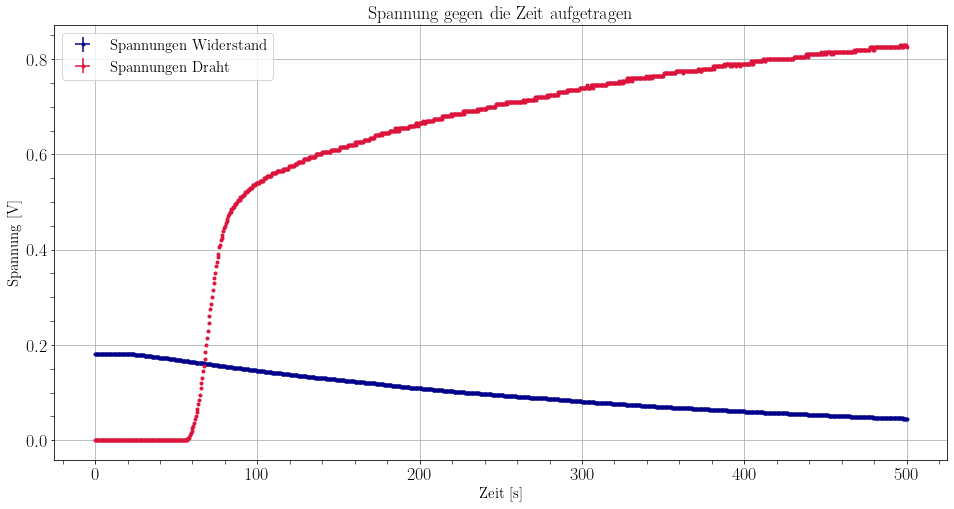

In [13]:
# Plotgröße anpassen
plt.figure(figsize=(16, 8))

# Gemessene Spannungswerte auftragen
plt.errorbar(zeitMessung1HTS, spannungUA1Messung1HTS, xerr=0, yerr=0, 
             fmt='.', color='darkblue', label='Spannungen Widerstand')

plt.errorbar(zeitMessung1HTS, spannungUB1Messung1HTS, xerr=0, yerr=0, 
             fmt='.', color='crimson', label='Spannungen Draht')

# labels und legend
plt.xlabel(r'Zeit [s]')
plt.ylabel(r'Spannung [V]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Zeit aufgetragen')
plt.show()

### Umwandlung der Spannung des Widerstandsthermometers in eine Temperatur

In [14]:
# Umwandlung Spannung -> Temperatur für Supraleiter
spannungKalt = 192.35e-3 # V
spannungWarm = -9.8e-3   # V

tempFlüssigerStickstoff = 77 # °K
tempRaum = 293.15             # °K = 20 °C
tempErr = 1

m = bestM(np.array([spannungKalt, spannungWarm]),np.array([tempFlüssigerStickstoff, tempRaum])) # °K/V
b = bestB(np.array([spannungKalt, spannungWarm]),np.array([tempFlüssigerStickstoff, tempRaum])) # °K

temperaturMessung1HTS = spannungUA1Messung1HTS*(m) + b
temperaturMessung1HTSErr = spannungErr/spannungUA1Messung1HTS*(m) + (spannungErr/spannungUA1Messung1HTS)*b

### Umwandlung der Schaltkreisspannung in einen Widerstand

In [15]:
widerstandMessung1HTS = np.array([])
widerstandMessung1HTSErr = np.array([])

for el in spannungUB1Messung1HTS:
    widerstand, widerstandErr = DivisionMitFehler(el, spannungErr,stromStärke,stromStärkeErr)
    widerstandMessung1HTS = np.append(widerstandMessung1HTS, widerstand)
    widerstandMessung1HTSErr = np.append(widerstandMessung1HTSErr, widerstandErr)

tempKritHTS = temperaturMessung1HTS[114]
tempKritHTSErr = abs(temperaturMessung1HTSErr[114])

<ipython-input-3-8ab7db670773>:31: RuntimeWarning: divide by zero encountered in double_scalars
  deltaC = abs(C) * math.sqrt((deltaA / A)**2 + (deltaB / B)**2)
<ipython-input-3-8ab7db670773>:31: RuntimeWarning: invalid value encountered in double_scalars
  deltaC = abs(C) * math.sqrt((deltaA / A)**2 + (deltaB / B)**2)


### Aufzeichnen der Daten

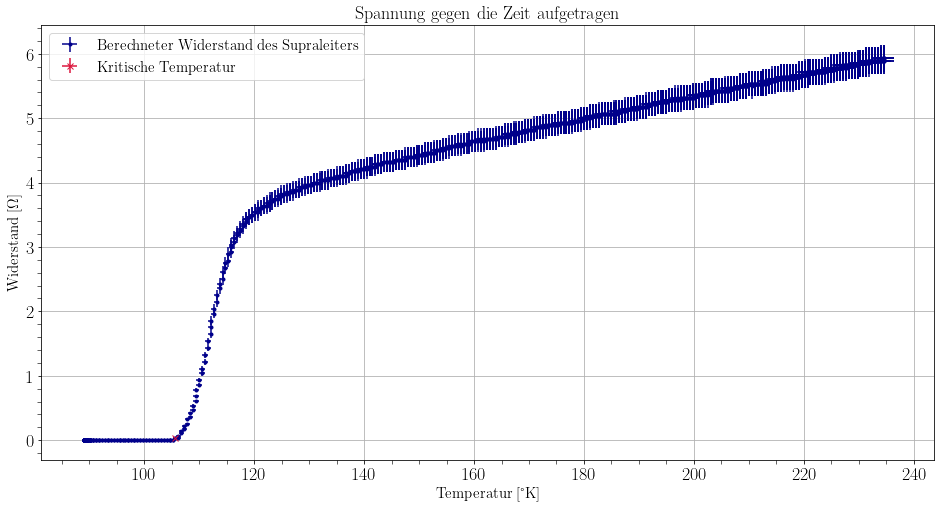

Der Wert der kritischen Temperatur beträgt: $105.7 \pm 0.5$ [°K]

In [16]:
# Plotgröße anpassen
plt.figure(figsize=(16, 8))

# Daten zeichnen
plt.errorbar(temperaturMessung1HTS, widerstandMessung1HTS, xerr=temperaturMessung1HTSErr, yerr=widerstandMessung1HTSErr, 
             fmt='.', color='darkblue', label='Berechneter Widerstand des Supraleiters')

# Kritische Temperatur einzeichnen
plt.errorbar(tempKritHTS, widerstandMessung1HTS[114], xerr=tempKritHTSErr, yerr=widerstandMessung1HTSErr[114],
                                    fmt='x', color='crimson', label='Kritische Temperatur')


# labels und legend
plt.xlabel(r'Temperatur [°K]')
plt.ylabel(r'Widerstand [$\Omega$]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Zeit aufgetragen')
plt.show()

md(f"""Der Wert der kritischen Temperatur beträgt: ${tempKritHTS:.1f} \pm {tempKritHTSErr:.1f}$ [°K]""")

### Berechnung t-Werte

In [17]:
tHTS = vertraeglichkeit(tempKritHTS, 105, tempKritHTSErr, 0)

print(tHTS)

1.492833795985474


# Diskussion
## Zusammenfassung der Ergebnisse
Als kritische Temperatur des Kupferdrahtes $T_\text{c, cu}$ ergab sich:
$$
	T_\text{c, cu} = 255 \pm 3 \text{ °K}
$$
Damit können unsere Messungen die Literaturwerte der kritischen Temperatur des Kupferdrahtes nicht bestätigen, diese liegt eher um die 20 °K. Dabei betrag der Residualwiderstand $R_\text{res}$:
$$
	R_\text{res} = 215.9 \pm 0.4 \times 10^{-3}\Omega
$$
Dies stimmt auch (nicht) mit der Literatur überein.
Für die kritische Temperatur des Supraleiters und den dazugehörige t-Wert unter Vergleich mit einem Wert, der für diese Art von Leitern typisch ist (genaueres hierzu in der Präsentation), $t_\text{su}$ wurden folgende Werte ermittelt:
$$
	T_\text{c, su} = 105.7 \pm 0.5 \text{ °K} \quad  t_\text{su} \approx 1.5
$$.\\


# Verbesserte Messmethoden
Das Thermometer könnte besser Kalibriert werden, durch hinzunahme weiterer bekannter Temperaturen für jene, etwa 0 C°, könnte die Genauigkeit der Eichung erhöht werden.